In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [65]:
df = pd.read_csv("/content/drive/MyDrive/20212/class/tich-hop-du-lieu/bai-tap-lon/real-estate-integration/prj-exam/data-matching/final_data_full_feature.csv")

In [41]:
df.select_dtypes(include=['object']).columns

Index(['title', 'description', 'square', 'name_contact', 'phone_contact',
       'date', 'direct', 'street', 'floor', 'juridical', 'bedroom', 'length',
       'width', 'link_image', 'url_page', 'kitchen', 'parking', 'terrace',
       'type', 'district', 'province', 'ward'],
      dtype='object')

In [42]:
df.select_dtypes(include=['int64','float64']).columns

Index(['price'], dtype='object')

In [43]:
df['price']

0        3.250000e+09
1        3.350000e+09
2        2.700000e+09
3        3.950000e+09
4        3.700000e+09
             ...     
25508    1.000000e+09
25509    1.000000e+09
25510    2.250000e+07
25511    1.290000e+09
25512    4.899000e+09
Name: price, Length: 25513, dtype: float64

In [66]:
df['price'].isna().sum()

1005

In [67]:
df = df[df['price'].notna()]

{'boxes': [<matplotlib.lines.Line2D at 0x7f78d5105e50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f78d510bf10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f78d5110f50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f78d5110a10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f78d510b490>,
  <matplotlib.lines.Line2D at 0x7f78d510b9d0>]}

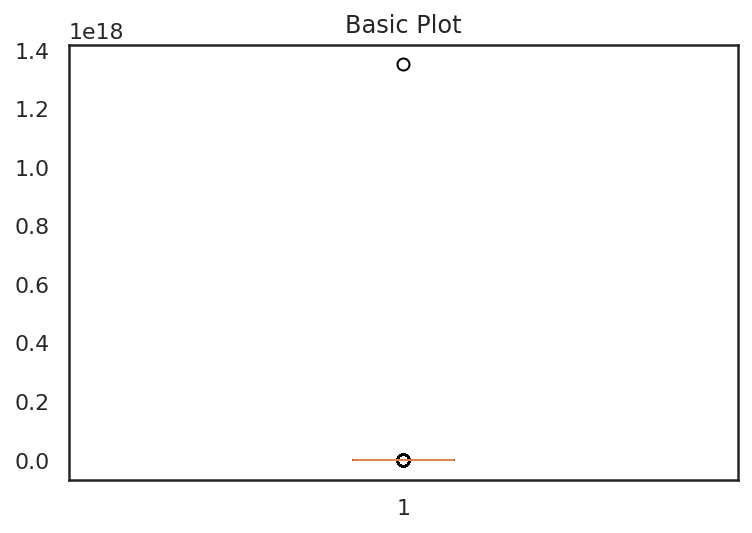

In [46]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(df['price'])


 mu = 3023808978.77 and sigma = 3636221990.34



Text(0.5, 1.0, 'SalePrice distribution')

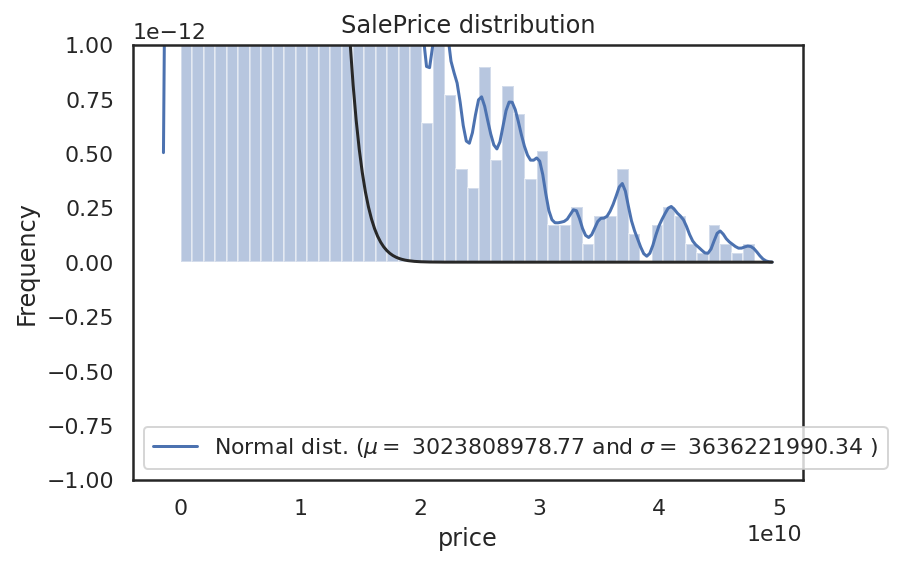

In [71]:
sns.distplot(df['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


In [70]:
df=(df[df.price < 5e10])
df.reset_index(drop=True, inplace=True)

In [72]:
df.shape

(24423, 23)

In [76]:
df["square"]

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
24418     65.0
24419     65.0
24420    120.0
24421     64.0
24422     43.0
Name: square, Length: 24423, dtype: float64

In [75]:
def rm_m(x):
    if(x == 'KXĐ'):
      return 0
    return str(x).replace("m","").strip().replace(".","")
df["square"] = df["square"].apply(rm_m)
df['square'] = df['square'].astype(str).astype(float)


In [77]:
# df=(df[df.square != '8.600.000'])
df=(df[df.square > 0])
df.reset_index(drop=True, inplace=True)

In [78]:
df.shape

(24136, 23)


 mu = 73.08 and sigma = 27.56



Text(0.5, 1.0, 'SalePrice distribution')

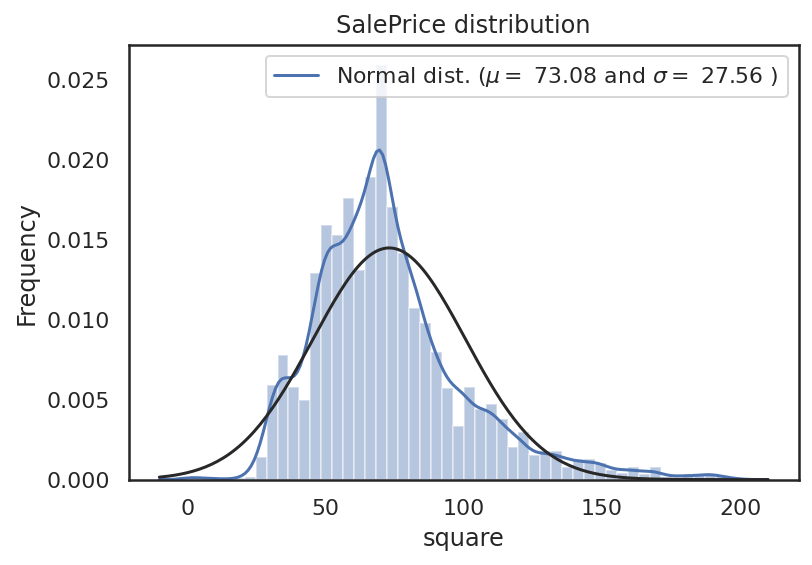

In [81]:
sns.distplot(df['square'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['square'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [80]:
df=(df[df.square < 200])
df.reset_index(drop=True, inplace=True)

In [82]:
df1 = df 

In [85]:
def convert_floor(x):
    
    x =  str(x).replace("t","").strip()
    if(x == ''):
      x = 0
    return x
df1["floor"] = df1["floor"].apply(convert_floor)
df1['floor'] = df1['floor'].astype(str).astype(float)

In [86]:
df1 = df1[df1.floor != 0]

In [89]:
def convert_bed(x):
    
    x =  str(x).replace("pn","").strip()
    if(x == ''):
      x = 0
    return x
df1["bedroom"] = df1["bedroom"].apply(convert_bed)
df1['bedroom'] = df1['bedroom'].astype(str).astype(float)

In [90]:
df1['parking']

1        Không
2        Không
3        Không
4        Không
6        Không
         ...  
23298      NaN
23299      NaN
23302      NaN
23303       Có
23305       Có
Name: parking, Length: 18486, dtype: object

In [111]:
df_meaning = df1[['square', 'floor', 'bedroom', 'district', 'province', 'ward', 'price']]

In [92]:
df_meaning.select_dtypes(include=['int64','float64']).columns

Index(['square', 'floor', 'bedroom', 'price'], dtype='object')

In [94]:
df_meaning.select_dtypes(include=['object']).columns

Index(['district', 'province', 'ward'], dtype='object')

In [93]:
df_meaning.shape

(18486, 7)

In [133]:
df_meaning = df_meaning[df_meaning['bedroom'].notna()]

In [134]:
df_meaning.shape

(17999, 7)

In [135]:
all_data = df_meaning.copy()

In [136]:
from sklearn.preprocessing import LabelEncoder
cols = (['district', 'province', 'ward'])
# Process columns and apply LabelEncoder to categorical features
lbl ={}
for c in cols:
    lbl[c] = LabelEncoder() 
    lbl[c].fit(list(all_data[c].values)) 
    all_data[c] = lbl[c].transform(list(all_data[c].values))

# Check shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (17999, 7)


In [137]:
all_data.isna().sum()

square      0
floor       0
bedroom     0
district    0
province    0
ward        0
price       0
dtype: int64

In [138]:
df_meaning

,square,floor,bedroom,district,province,ward,price
1,90.0,2.0,3.0,3,Hồ Chí Minh,1,2.650000e+09
2,90.0,2.0,3.0,3,Hồ Chí Minh,1,2.650000e+09
3,36.0,1.0,1.0,3,Hồ Chí Minh,1,4.600000e+09
4,78.0,1.0,3.0,3,Hồ Chí Minh,1,3.400000e+09
6,85.0,12.0,2.0,4,Hồ Chí Minh,1,3.400000e+09
...,...,...,...,...,...,...,...
23298,102.0,1.0,3.0,None,Hà Nội,Đức Giang,3.950000e+09
23299,81.0,1.0,3.0,None,TP. Hà Nội,Đức Giang,2.300000e+09
23302,65.0,1.0,2.0,None,Lộ 10,Đức Hoà Đông,1.000000e+09
23303,120.0,1.0,2.0,Đức Hòa,lộ 823,Đức Lập Thượng,2.250000e+07


In [116]:
lbl['district'].transform(["Bắc Từ Liêm"])

array([23])

In [139]:
X = all_data[['square', 'floor', 'bedroom','district', 'province', 'ward']]
y = all_data[['price']]

In [142]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [143]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)


LinearRegression()

In [144]:
y_pred = linreg.predict(X_test)

from sklearn.metrics import mean_absolute_error,mean_squared_error
 
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)

#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
 
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 1508393292.7438958
MSE: 9.499058064510902e+18
RMSE: 3082054195.583021


In [146]:
X_test[1:2]

,square,floor,bedroom,district,province,ward
9582,32.0,7.0,2.0,60,11,287


In [148]:
y_test[1:2]

,price
9582,650000000.0


In [149]:
y_pred = linreg.predict(X_test[1:2])

In [150]:
y_pred

array([[7.67307131e+08]])

In [161]:
input ={
    'square' : 50, 
    'floor' :2, 
    'bedroom':2,
    'district':['Bắc Từ Liêm'], 
    'province':['Hà Nội'], 
    'ward':['Đức Thắng']
}

In [162]:
cols = (['district', 'province', 'ward'])

sample = pd.DataFrame()

for c in cols: 
  sample[c] = lbl[c].transform(input[c])

cols_num = (['square', 'floor', 'bedroom'])
for c in cols_num: 
  sample[c] = float(input[c])

['Bắc Từ Liêm']
['Hà Nội']
['Đức Thắng']


In [166]:
y_pred = linreg.predict(sample[0:1])

In [167]:
y_pred

array([[1.63327731e+10]])

In [ ]:
!pip install fastapi

In [169]:
from pydantic import BaseModel

class PriceModel(BaseModel):
    square : float
    floor :float 
    bedroom:float
    district: list
    province:list
    ward:list

In [170]:
from fastapi import FastAPI
import pickle

app = FastAPI()

@app.on_event("startup")
def load_model(): 
    global model
    model =  linreg

@app.get('/')
def index():
    return {'message': 'This is the homepage of the API '}


@app.post('/predict')
def get_music_category(data: PriceModel):
    input = data.dict()

    cols = (['district', 'province', 'ward'])

    sample = pd.DataFrame()

    for c in cols: 
      sample[c] = lbl[c].transform(input[c])

    cols_num = (['square', 'floor', 'bedroom'])
    for c in cols_num: 
      sample[c] = float(input[c])

    
    pred_price  = model.predict(sample[0:1]).tolist()[0]
    return {'prediction': pred_price}

In [ ]:
!pip install colabcode

In [175]:
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)

In [ ]:
server.run_app(app=app)

INFO:     Started server process [56]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:10000 (Press CTRL+C to quit)


Public URL: NgrokTunnel: "https://c489-34-86-204-47.ngrok.io" -> "http://localhost:10000"
INFO:     2001:ee0:4001:1c7d:18d2:f4b:2a24:32a8:0 - "GET / HTTP/1.1" 200 OK
INFO:     2001:ee0:4001:1c7d:18d2:f4b:2a24:32a8:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
